In [1]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math

In [4]:
#import pyshp
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [14]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [18]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [26]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [27]:
sf = shapefile.Reader("taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough     longitude       latitude  
0            EWR  9.366817e+05  190522.130278  
1         Queens  1.033536e+06  161853.982300  
2          Bronx  1.027136e+06  254730.010849  
3      Manhattan  9.904240e+05  203100.040432  
4  Staten Island  9.321332e+05  139954.541936

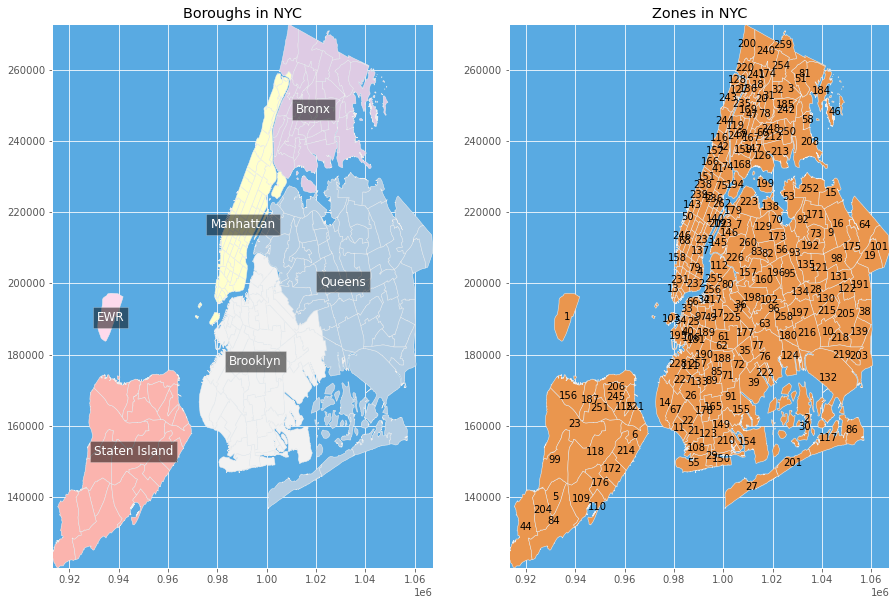

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

In [150]:
def draw_dropoff_heatmap(time):
    df = pd.read_csv('pickup_dropoff_summary.csv')
    df = df.loc[(df['time_window'] == time)] 
    df = df[['zone', 'time_window', 'zone_name', 'zone_borough','time_window', 'weekday_dropoff', 'weekend_dropoff',
           'time_start', 'time_end']]
    df['time_range'] = df['time_start'].astype(str) + "-" + df['time_end']
    time_range = df['time_range'].values[0]
    count_weekday = dict(zip(df['zone'].tolist(), df['weekday_dropoff'].tolist()))
    count_weekend = dict(zip(df['zone'].tolist(), df['weekend_dropoff'].tolist()))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
    ax = plt.subplot(1, 2, 1)
    ax.set_title( str(time_range) + " zones dropoff heatmap weekday")
    draw_zone_map(ax, sf, heat=count_weekday)
    ax = plt.subplot(1, 2, 2)
    ax.set_title( str(time_range) + " zones dropoff heatmap weekend")
    draw_zone_map(ax, sf, heat=count_weekend)

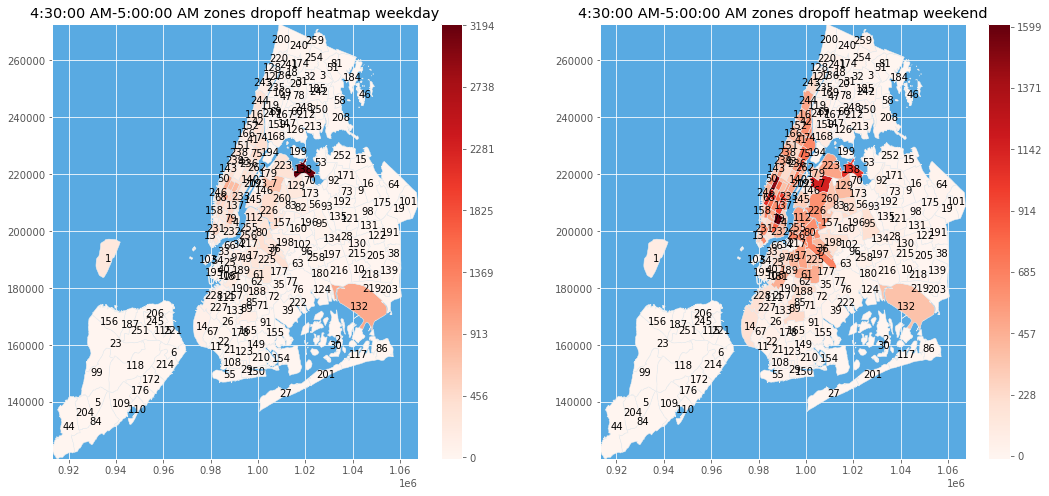

In [165]:
draw_dropoff_heatmap(time = 10)

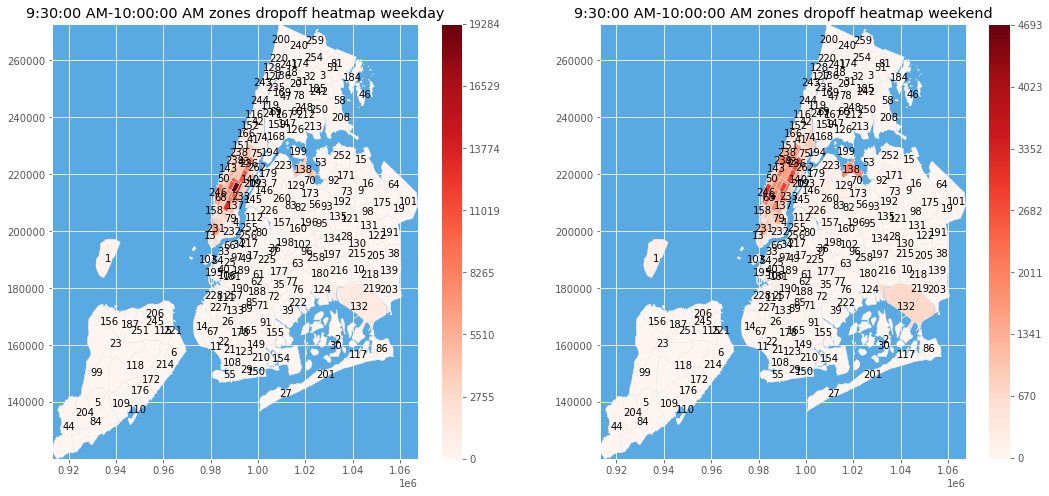

In [164]:
draw_dropoff_heatmap(time = 20)

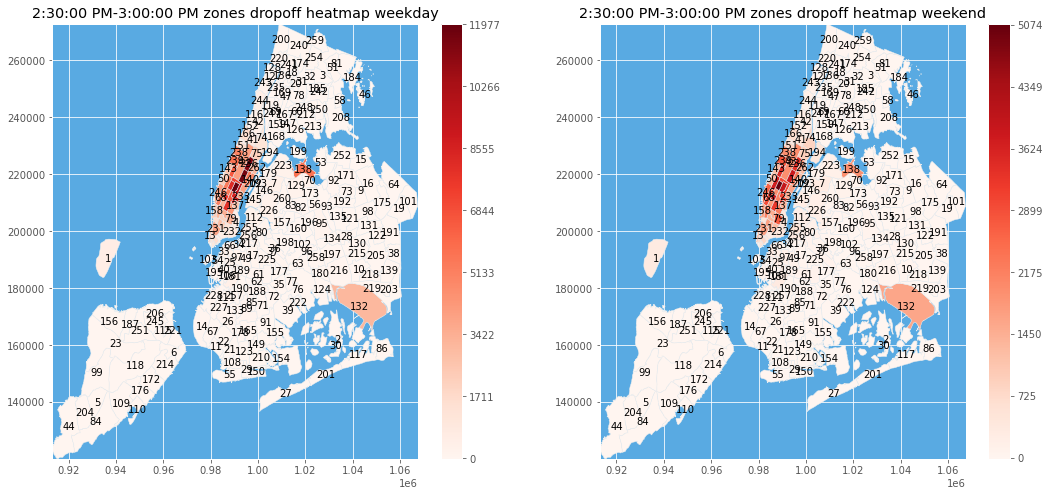

In [166]:
draw_dropoff_heatmap(time = 30)

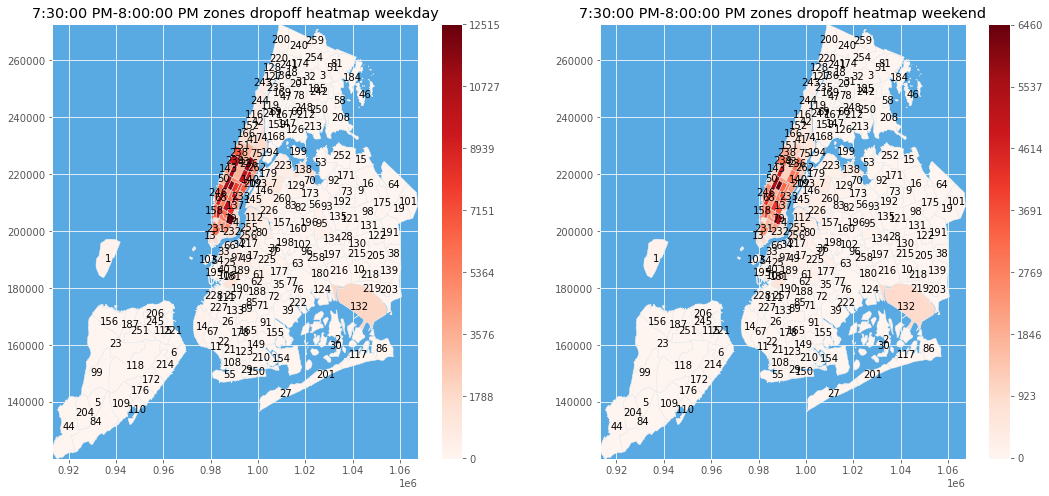

In [167]:
draw_dropoff_heatmap(time = 40)

In [171]:
def draw_pro_pickup_heatmap(time):
    df = pd.read_csv('pickup_dropoff_summary.csv')
    prob = pd.read_csv('all_prob.csv')
    prob = prob.loc[(prob['time_window'] == time)] 
    prob = prob[['taxi_zone', 'time_window', 'prob_pu_weekday', 'prob_pu_weekend', 'prob_near_arr_weekday', 
                 'prob_near_arr_weekend']]
    df['time_range'] = df['time_start'].astype(str) + "-" + df['time_end']
    prob['time_range'] = df['time_range']
    time_range = prob['time_range'].values[0]
    
    
    prob_weekday = dict(zip(prob['taxi_zone'].tolist(), prob['prob_pu_weekday'].tolist()))
    prob_weekend = dict(zip(prob['taxi_zone'].tolist(), prob['prob_pu_weekend'].tolist()))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
    ax = plt.subplot(1, 2, 1)
    ax.set_title( str(time_range) + " pickup probability heatmap weekday")
    draw_zone_map(ax, sf, heat=prob_weekday)
    ax = plt.subplot(1, 2, 2)
    ax.set_title( str(time_range) + " pickup probability heatmap weekend")
    draw_zone_map(ax, sf, heat=prob_weekend)

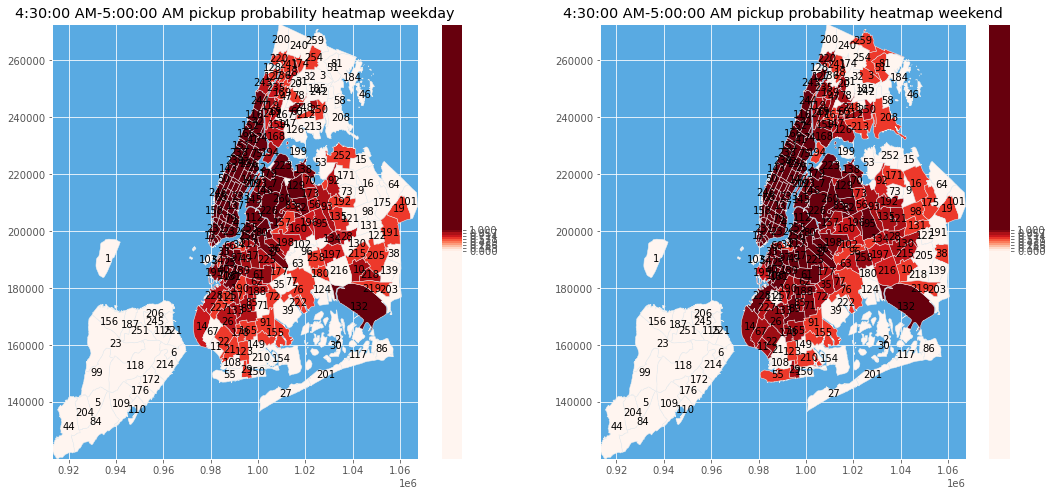

In [172]:
draw_pro_pickup_heatmap(10)

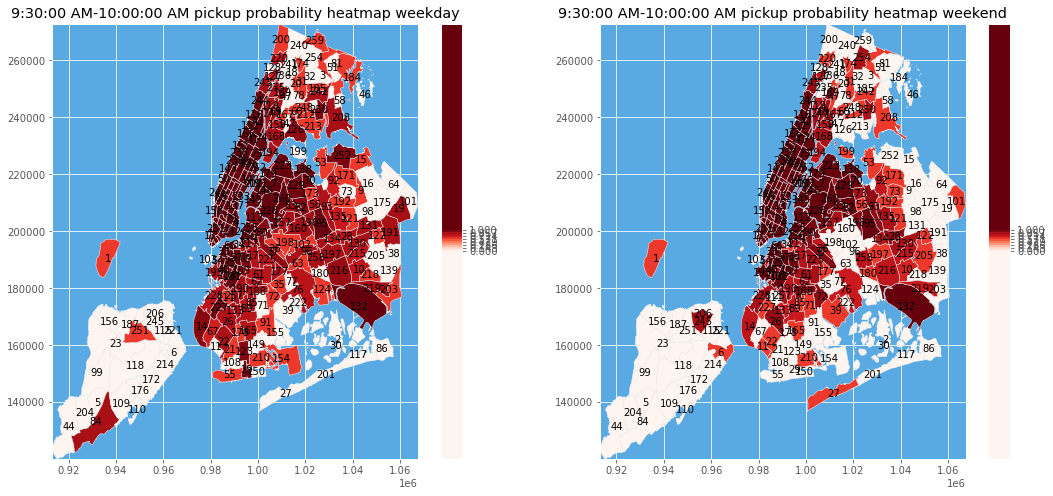

In [173]:
draw_pro_pickup_heatmap(20)

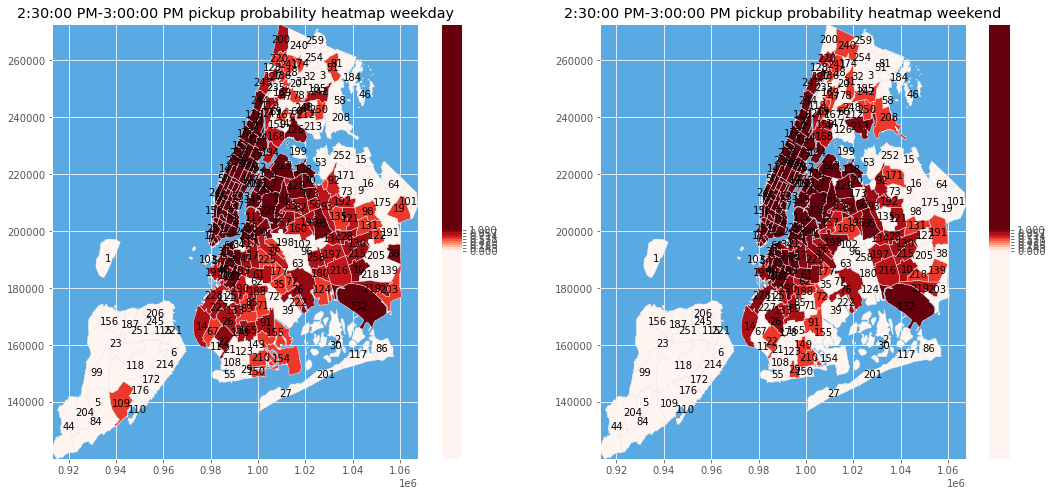

In [174]:
draw_pro_pickup_heatmap(30)

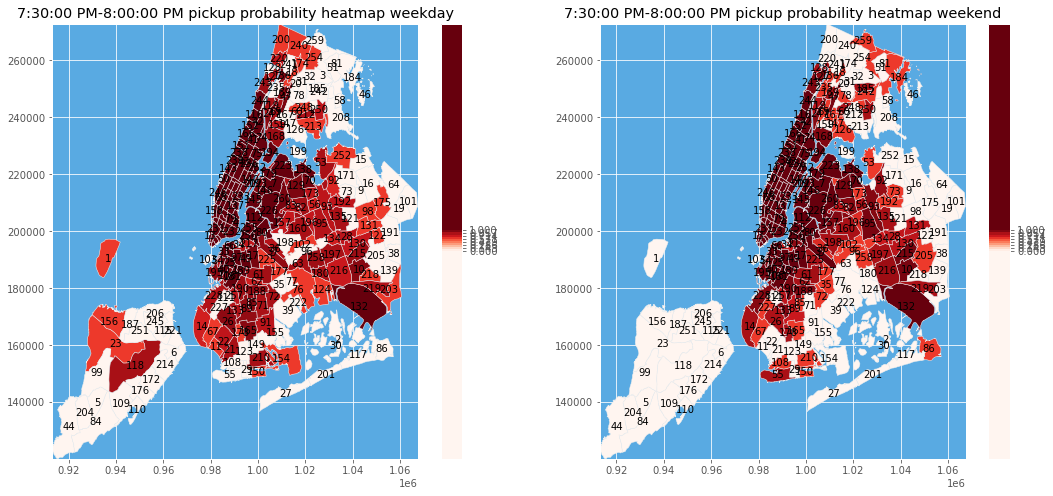

In [175]:
draw_pro_pickup_heatmap(40)

In [177]:
def draw_pro_near_arrival_heatmap(time):
    df = pd.read_csv('pickup_dropoff_summary.csv')
    prob = pd.read_csv('all_prob.csv')
    prob = prob.loc[(prob['time_window'] == time)] 
    prob = prob[['taxi_zone', 'time_window', 'prob_pu_weekday', 'prob_pu_weekend', 'prob_near_arr_weekday', 
                 'prob_near_arr_weekend']]
    df['time_range'] = df['time_start'].astype(str) + "-" + df['time_end']
    prob['time_range'] = df['time_range']
    time_range = prob['time_range'].values[0]
    
    
    prob_weekday = dict(zip(prob['taxi_zone'].tolist(), prob['prob_near_arr_weekday'].tolist()))
    prob_weekend = dict(zip(prob['taxi_zone'].tolist(), prob['prob_near_arr_weekend'].tolist()))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
    ax = plt.subplot(1, 2, 1)
    ax.set_title( str(time_range) + " probability of arrival heatmap weekday")
    draw_zone_map(ax, sf, heat=prob_weekday)
    ax = plt.subplot(1, 2, 2)
    ax.set_title( str(time_range) + " probability of arrival heatmap weekend")
    draw_zone_map(ax, sf, heat=prob_weekend)

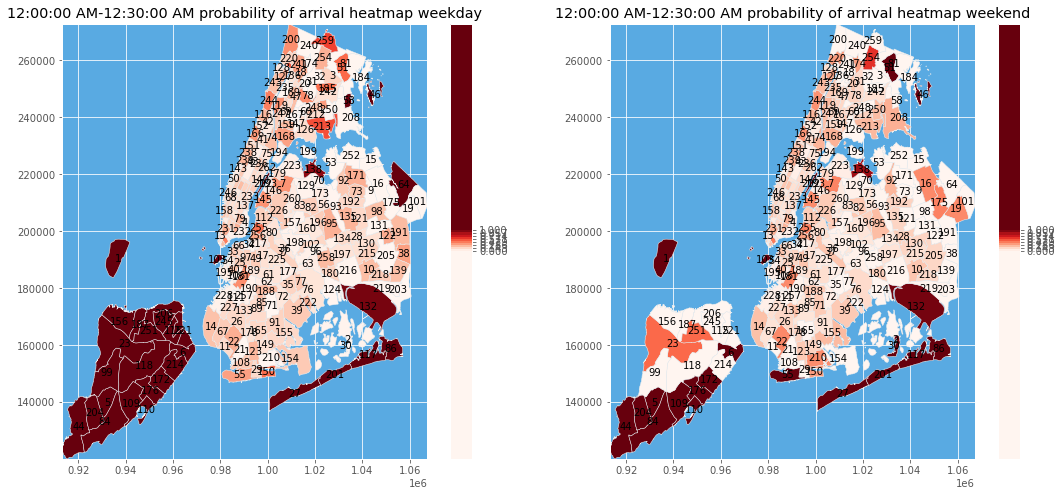

In [163]:
draw_pro_near_arrival_heatmap(time = 1)

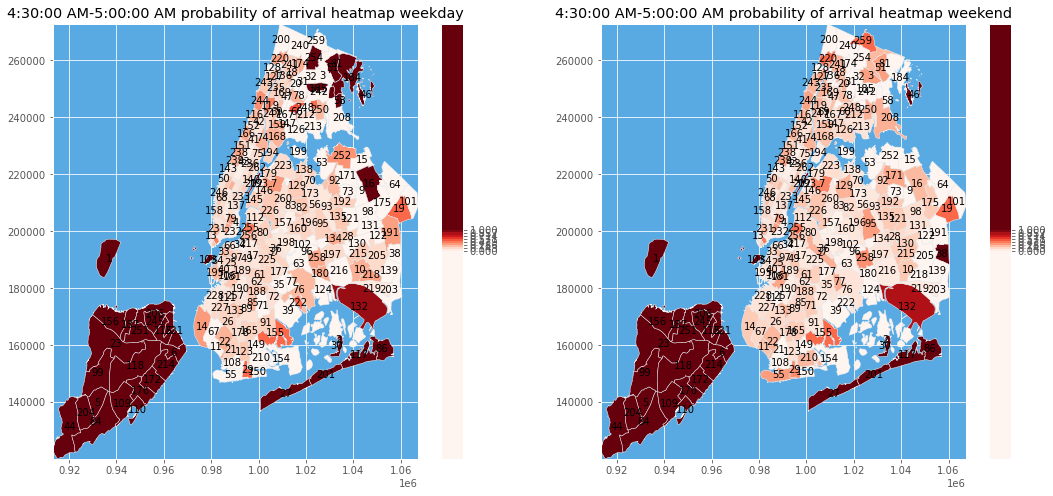

In [178]:
draw_pro_near_arrival_heatmap(time = 10)

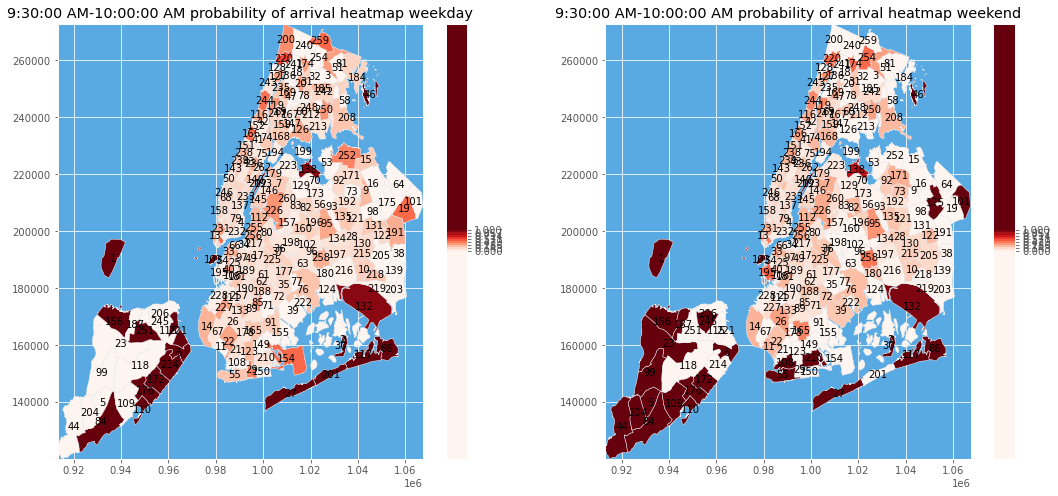

In [179]:
draw_pro_near_arrival_heatmap(time = 20)

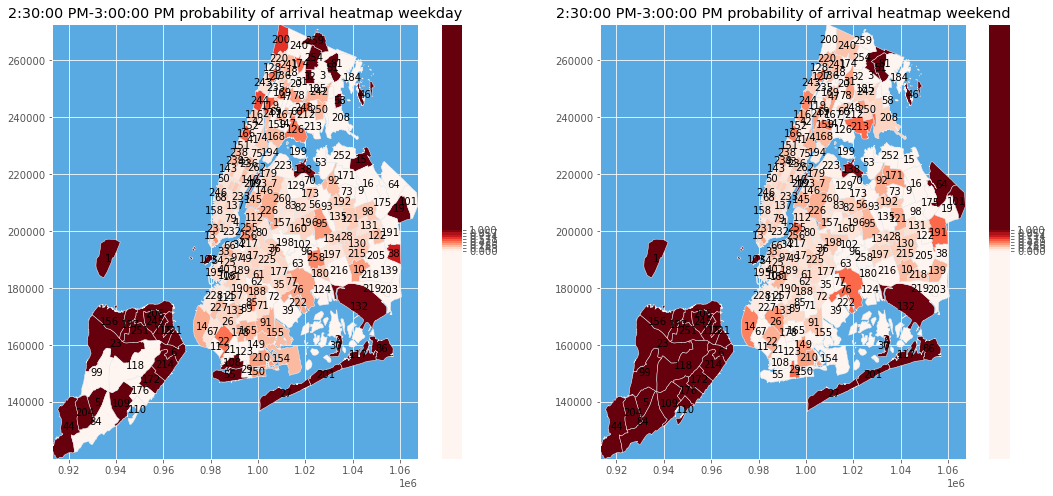

In [180]:
draw_pro_near_arrival_heatmap(time = 30)

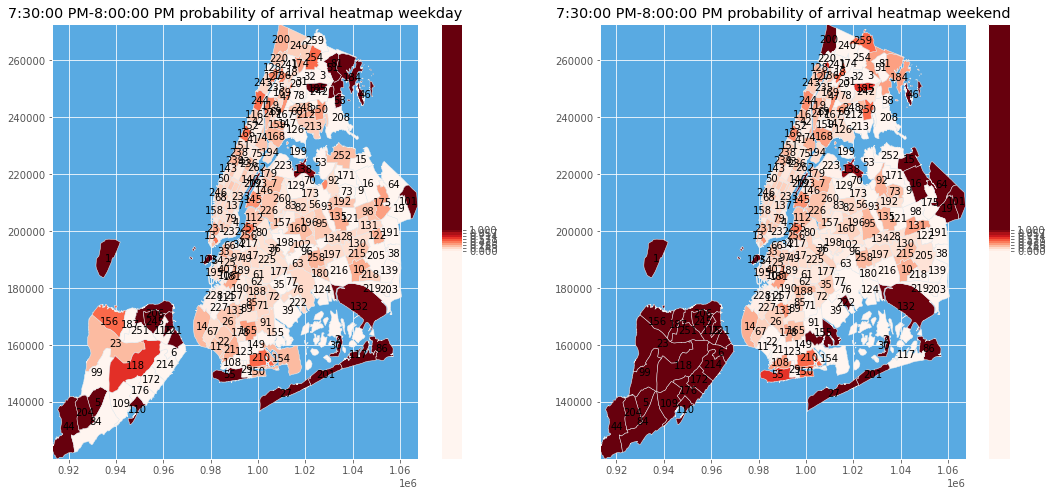

In [181]:
draw_pro_near_arrival_heatmap(time = 40)

In [131]:
df = pd.read_csv('pickup_dropoff_summary.csv')
print(df.columns.tolist())
df['time_range'] = df['time_start'].astype(str) + "-" + df['time_end']
df['time_range'][0]


['Unnamed: 0', 'zone', 'time_window', 'weekday_pickup', 'weekend_pickup', 'weekday_dropoff', 'weekend_dropoff', 'weekday_differentials', 'weekend_differentials', 'supply_surplus_weekday', 'supply_surplus_weekend', 'zone_name', 'zone_borough', 'time_start', 'time_end']


'12:00:00 AM-12:30:00 AM'

In [68]:
df = df.loc[(df['time_window'] == 1)] 
df = df[['zone', 'time_window', 'zone_name', 'zone_borough', 'weekday_dropoff', 'weekend_dropoff']]
df

zone  time_window                zone_name   zone_borough  \
0         1            1           Newark Airport            EWR   
48        2            1              Jamaica Bay         Queens   
96        3            1  Allerton/Pelham Gardens          Bronx   
144       4            1            Alphabet City      Manhattan   
192       5            1            Arden Heights  Staten Island   
...     ...          ...                      ...            ...   
12384   259            1       Woodlawn/Wakefield          Bronx   
12432   260            1                 Woodside         Queens   
12480   261            1       World Trade Center      Manhattan   
12528   262            1           Yorkville East      Manhattan   
12576   263            1           Yorkville West      Manhattan   

       weekday_dropoff  weekend_dropoff  
0                    8                1  
48                   2                0  
96                  29                6  
144               1354             1168  
192                  2                0  
...                ...              ...  
12384               47               27  
12432              582              280  
12480             1043              678  
12528             2324             1518  
12576             4022             2815  

[263 rows x 6 columns]

In [85]:
def create_weekday_dropoff_df(time, df):
    df = df.loc[(df['time_window'] == time)] 
    df = df[['zone', 'time_window', 'zone_name', 'zone_borough','time_window', 'weekday_dropoff', 'weekend_dropoff']]
    return df


In [86]:
df_1 = create_weekday_dropoff_df(1,df)

In [87]:
df_1

zone  time_window                zone_name   zone_borough  time_window  \
0         1            1           Newark Airport            EWR            1   
48        2            1              Jamaica Bay         Queens            1   
96        3            1  Allerton/Pelham Gardens          Bronx            1   
144       4            1            Alphabet City      Manhattan            1   
192       5            1            Arden Heights  Staten Island            1   
...     ...          ...                      ...            ...          ...   
12384   259            1       Woodlawn/Wakefield          Bronx            1   
12432   260            1                 Woodside         Queens            1   
12480   261            1       World Trade Center      Manhattan            1   
12528   262            1           Yorkville East      Manhattan            1   
12576   263            1           Yorkville West      Manhattan            1   

       weekday_dropoff  weekend_dropoff  
0                    8                1  
48                   2                0  
96                  29                6  
144               1354             1168  
192                  2                0  
...                ...              ...  
12384               47               27  
12432              582              280  
12480             1043              678  
12528             2324             1518  
12576             4022             2815  

[263 rows x 7 columns]

In [88]:
df_1['zone']

0          1
48         2
96         3
144        4
192        5
        ... 
12384    259
12432    260
12480    261
12528    262
12576    263
Name: zone, Length: 263, dtype: int64

In [90]:
count = dict(zip(df_1['zone'].tolist(), df_1['weekday_dropoff'].tolist()))
count

{1: 8,
 2: 2,
 3: 29,
 4: 1354,
 5: 2,
 6: 9,
 7: 2998,
 8: 10,
 9: 16,
 10: 103,
 11: 35,
 12: 70,
 13: 1513,
 14: 466,
 15: 25,
 16: 46,
 17: 1029,
 18: 47,
 19: 15,
 20: 28,
 21: 65,
 22: 94,
 23: 13,
 24: 813,
 25: 929,
 26: 80,
 27: 4,
 28: 118,
 29: 28,
 30: 4,
 31: 2,
 32: 20,
 33: 1256,
 34: 35,
 35: 40,
 36: 560,
 37: 1039,
 38: 14,
 39: 48,
 40: 668,
 41: 1513,
 42: 1252,
 43: 1225,
 44: 5,
 45: 570,
 46: 8,
 47: 26,
 48: 6443,
 49: 1293,
 50: 1857,
 51: 34,
 52: 405,
 53: 31,
 54: 146,
 55: 27,
 56: 115,
 57: 11,
 58: 9,
 59: 0,
 60: 12,
 61: 1125,
 62: 266,
 63: 24,
 64: 20,
 65: 728,
 66: 393,
 67: 66,
 68: 5157,
 69: 99,
 70: 135,
 71: 36,
 72: 44,
 73: 41,
 74: 1491,
 75: 2068,
 76: 55,
 77: 21,
 78: 27,
 79: 7053,
 80: 1632,
 81: 13,
 82: 458,
 83: 251,
 84: 2,
 85: 52,
 86: 10,
 87: 2175,
 88: 644,
 89: 431,
 90: 3067,
 91: 65,
 92: 120,
 93: 31,
 94: 31,
 95: 738,
 96: 16,
 97: 914,
 98: 25,
 99: 0,
 100: 1963,
 101: 14,
 102: 49,
 103: 0,
 104: 0,
 105: 0,
 106: 346,

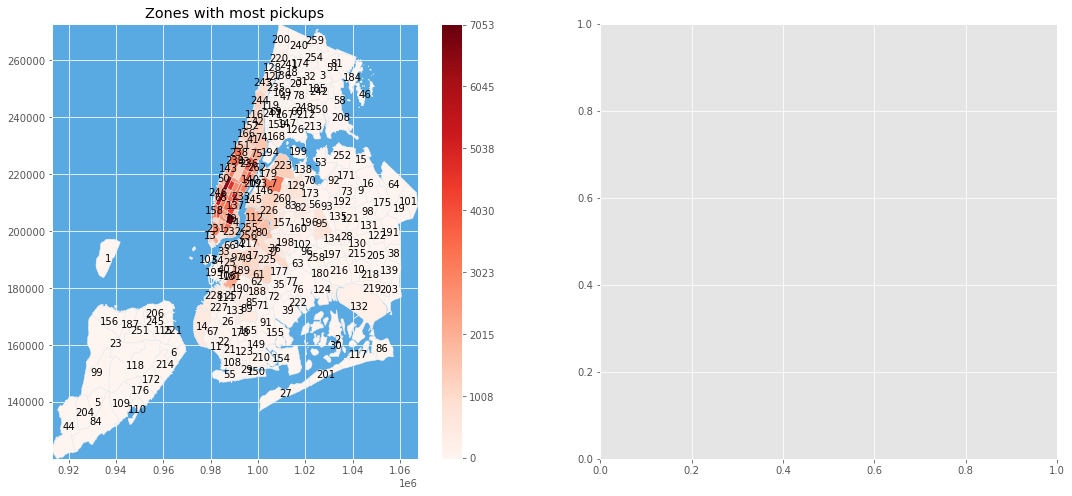

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, heat=count)
# ax = plt.subplot(1, 2, 2)
# ax.set_title("Zones with most drop-offs")
# draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())